In [136]:
import numpy as np
import pandas as pd

In [137]:
from sklearn.preprocessing import RobustScaler


In [138]:
df = pd.read_csv('../data/df_train.csv')
df_test = pd.read_csv('../data/df_test.csv')
df['ShapeFactor5'] = df['MajorAxisLength'] / df['Perimeter']
df_test['ShapeFactor5'] = df_test['MajorAxisLength'] / df_test['Perimeter']


# Użyteczne funkcje


In [139]:
def normalize_column(df, column):
    return RobustScaler().fit_transform(np.array(df[column]).reshape(-1, 1))

In [140]:
def replace_outliers(data):
    for column in data.columns:
        if data[column].dtype in ['int64', 'float64']:  # tylko dla kolumn numerycznych
            Q1 = data.groupby('Class')[column].quantile(0.25)
            Q3 = data.groupby('Class')[column].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            mean = data.groupby('Class')[column].mean()
            for class_name in data['Class'].unique():
                data.loc[(data['Class'] == class_name) & (data[column] < lower_bound[class_name]), column] = mean[class_name]
                data.loc[(data['Class'] == class_name) & (data[column] > upper_bound[class_name]), column] = mean[class_name]
    return data

In [141]:
def prepare_train_data(df):
    for col in df.columns:
        if col != "Class":
            df[col] = normalize_column(df, col)
    replace_outliers(df)
    return df

In [142]:
def prepare_test_data(df):
    for col in df.columns:
        if col != "Class":
            df[col] = normalize_column(df, col)
    return df

In [143]:
def select_columns(df):
    columns = ['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 
               'AspectRation', 'Eccentricity', 'roundness', 'Extent',
               'Solidity','ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4', 'Class', 'ShapeFactor5']
    df = df[columns]
    return df

In [144]:
def select_columns_mlp(df):
    columns = ['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 
               'AspectRation', 'Eccentricity', 'roundness', 'Extent',
               'Solidity','ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4', 'Class']
    df = df[columns]
    return df

In [145]:
data = select_columns(df.copy())
data = prepare_train_data(data)
data_test = select_columns(df_test.copy())
data_test = prepare_test_data(data_test)
X_train = data.drop(columns=["Class"])
y_train = data["Class"]
X_test = data_test.drop(columns=["Class"])
y_test = data_test["Class"]

# Testowanie modeli

## Random Forest

In [150]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_confusion_matrix

In [112]:
rfc = RandomForestClassifier(n_estimators=80, criterion='entropy', max_depth=20, random_state=311, max_features=None,
                             warm_start=True)

rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


Accuracy: 0.9185029730675062
Balanced accuracy: 0.931005937507863
              precision    recall  f1-score   support

    BARBUNYA       0.94      0.92      0.93       278
      BOMBAY       0.99      1.00      1.00       109
        CALI       0.94      0.94      0.94       342
    DERMASON       0.91      0.91      0.91       745
       HOROZ       0.96      0.93      0.94       405
       SEKER       0.95      0.95      0.95       426
        SIRA       0.84      0.86      0.85       554

    accuracy                           0.92      2859
   macro avg       0.93      0.93      0.93      2859
weighted avg       0.92      0.92      0.92      2859



## SVC

Accuracy: 0.9153550192374956
Balanced accuracy: 0.929181645683556

              precision    recall  f1-score   support

    BARBUNYA       0.86      0.94      0.90       278
      BOMBAY       0.93      1.00      0.96       109
        CALI       0.95      0.95      0.95       342
    DERMASON       0.90      0.91      0.91       745
       HOROZ       0.97      0.93      0.95       405
       SEKER       0.96      0.92      0.94       426
        SIRA       0.87      0.86      0.86       554

    accuracy                           0.92      2859
   macro avg       0.92      0.93      0.92      2859
weighted avg       0.92      0.92      0.92      2859



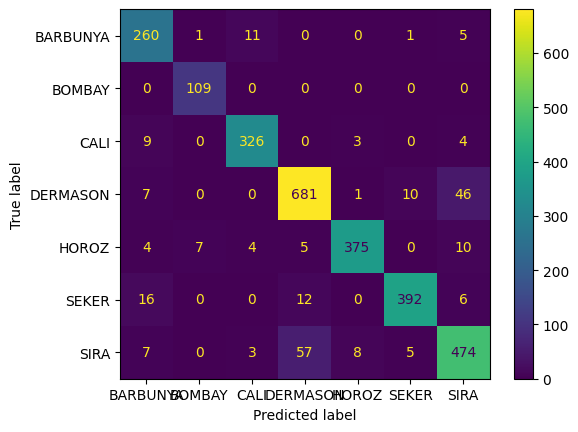

In [113]:
from sklearn.svm import SVC

svc = SVC(C=30, kernel='rbf', random_state=311, tol=1e-1, probability=True)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
disp.plot()

## Kroswalidacja SVC

In [151]:
param_grid = {"C": [i for i in range(17, 40)], "kernel": ['rbf']}
grid_search = GridSearchCV(svc, param_grid=param_grid, cv=7, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train, y_train)

KeyboardInterrupt: 

Accuracy: 0.9538300104931794
Balanced accuracy: 0.9626093363714602

              precision    recall  f1-score   support

    BARBUNYA       0.97      0.95      0.96       278
      BOMBAY       1.00      1.00      1.00       109
        CALI       0.96      0.98      0.97       342
    DERMASON       0.93      0.94      0.94       745
       HOROZ       1.00      0.97      0.98       405
       SEKER       0.98      0.98      0.98       426
        SIRA       0.91      0.91      0.91       554

    accuracy                           0.95      2859
   macro avg       0.96      0.96      0.96      2859
weighted avg       0.95      0.95      0.95      2859



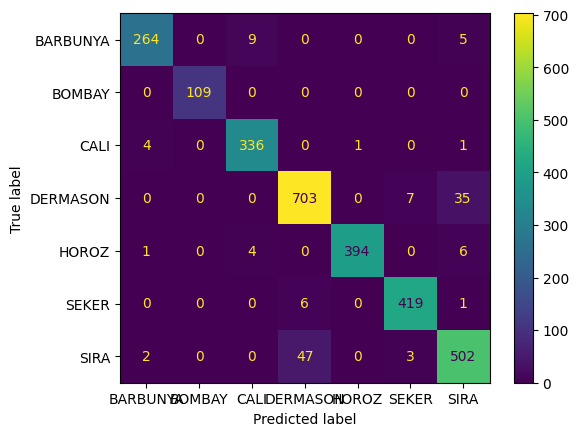

In [ ]:
final_svc = grid_search.best_estimator_
final_svc.fit(X_train, y_train)
final_svc.predict(X_test)
y_pred = final_svc.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=final_svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_svc.classes_)
disp.plot()

## MLP Classifier

Do tego lepiej pasują dane bez shapefactor5

In [115]:
df = pd.read_csv('../data/df_train.csv')
df_test = pd.read_csv('../data/df_test.csv')

data = select_columns_mlp(df.copy())
data = prepare_train_data(data)
data_test = select_columns_mlp(df_test.copy())
data_test = prepare_test_data(data_test)
X_train_mlp = data.drop(columns=["Class"])
y_train_mlp = data["Class"]
X_test_mlp = data_test.drop(columns=["Class"])
y_test_mlp = data_test["Class"]

Accuracy: 0.9195522910108429
Balanced accuracy: 0.9304003482838908

              precision    recall  f1-score   support

    BARBUNYA       0.89      0.95      0.92       278
      BOMBAY       1.00      0.99      1.00       109
        CALI       0.93      0.93      0.93       342
    DERMASON       0.90      0.93      0.91       745
       HOROZ       0.94      0.93      0.93       405
       SEKER       0.97      0.93      0.95       426
        SIRA       0.89      0.85      0.87       554

    accuracy                           0.92      2859
   macro avg       0.93      0.93      0.93      2859
weighted avg       0.92      0.92      0.92      2859



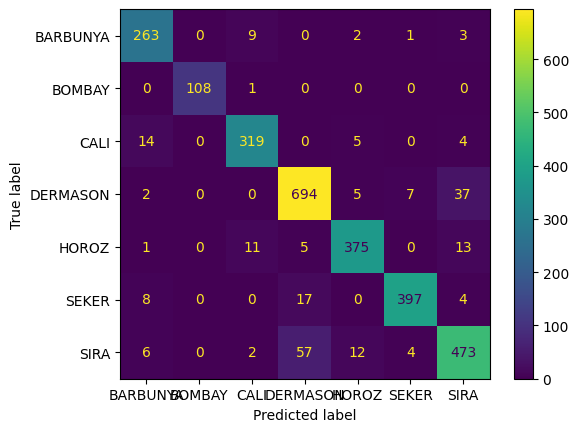

In [116]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=311, hidden_layer_sizes=(200,), activation='relu', solver='adam', alpha=0.0005, learning_rate='adaptive',
                    learning_rate_init=0.001, beta_1=0.1)
mlp.fit(X_train_mlp, y_train_mlp)
y_pred = mlp.predict(X_test_mlp)
print(f"Accuracy: {accuracy_score(y_test_mlp, y_pred)}")
print(f"Balanced accuracy: {balanced_accuracy_score(y_test_mlp, y_pred)}\n")
print(classification_report(y_test_mlp, y_pred))

cm = confusion_matrix(y_test_mlp, y_pred, labels=mlp.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp.classes_)
disp.plot()

## LGBM Classifier

In [117]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(objective='multiclass', random_state=311, learning_rate=0.15, reg_alpha=0.01, verbose=-1)

lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.9216509268975166
Balanced accuracy: 0.9321819072324865

              precision    recall  f1-score   support

    BARBUNYA       0.90      0.93      0.92       278
      BOMBAY       0.99      0.99      0.99       109
        CALI       0.94      0.93      0.93       342
    DERMASON       0.91      0.92      0.92       745
       HOROZ       0.96      0.94      0.95       405
       SEKER       0.95      0.94      0.95       426
        SIRA       0.88      0.86      0.87       554

    accuracy                           0.92      2859
   macro avg       0.93      0.93      0.93      2859
weighted avg       0.92      0.92      0.92      2859



## Nearest Neighbours


In [118]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='auto', weights ='distance', n_neighbors=15, p=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.899965022735222
Balanced accuracy: 0.9141807965839158

              precision    recall  f1-score   support

    BARBUNYA       0.93      0.89      0.91       278
      BOMBAY       1.00      1.00      1.00       109
        CALI       0.81      0.96      0.88       342
    DERMASON       0.90      0.89      0.90       745
       HOROZ       0.97      0.85      0.91       405
       SEKER       0.96      0.94      0.95       426
        SIRA       0.84      0.86      0.85       554

    accuracy                           0.90      2859
   macro avg       0.92      0.91      0.91      2859
weighted avg       0.90      0.90      0.90      2859



# Bagging (z kroswalidacją)

In [120]:
from sklearn.ensemble import BaggingClassifier

bc = BaggingClassifier(estimator=svc, n_estimators=10, random_state=311)

grid_search = GridSearchCV(bc, param_grid={"n_estimators": [2, 5, 10, 20, 30, 40]}, cv=7, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=7,
             estimator=BaggingClassifier(estimator=SVC(C=30, probability=True,
                                                       random_state=311,
                                                       tol=0.1),
                                         random_state=311),
             param_grid={'n_estimators': [2, 5, 10, 20, 30, 40]},
             return_train_score=True, scoring='accuracy')

In [121]:
final_bc = grid_search.best_estimator_
final_bc.fit(X_train, y_train)
y_pred = final_bc.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.919202518363064
Balanced accuracy: 0.934112998954404

              precision    recall  f1-score   support

    BARBUNYA       0.90      0.94      0.92       278
      BOMBAY       0.99      1.00      1.00       109
        CALI       0.95      0.95      0.95       342
    DERMASON       0.90      0.91      0.91       745
       HOROZ       0.95      0.96      0.95       405
       SEKER       0.96      0.93      0.95       426
        SIRA       0.86      0.85      0.86       554

    accuracy                           0.92      2859
   macro avg       0.93      0.93      0.93      2859
weighted avg       0.92      0.92      0.92      2859



### Bez kroswalidacji

In [122]:
bc = BaggingClassifier(estimator=svc, n_estimators=60, random_state=311)
bc.fit(X_train, y_train)
y_pred = bc.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.9195522910108429


# Boosting

## Ada Boost

In [123]:
ada = AdaBoostClassifier(estimator=rfc, algorithm='SAMME', n_estimators=500, random_state=311, learning_rate=0.01)

ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)}\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.9216509268975166
Balanced Accuracy: 0.9323868680303123

              precision    recall  f1-score   support

    BARBUNYA       0.93      0.91      0.92       278
      BOMBAY       0.99      1.00      1.00       109
        CALI       0.94      0.94      0.94       342
    DERMASON       0.91      0.92      0.92       745
       HOROZ       0.97      0.93      0.95       405
       SEKER       0.95      0.95      0.95       426
        SIRA       0.85      0.87      0.86       554

    accuracy                           0.92      2859
   macro avg       0.93      0.93      0.93      2859
weighted avg       0.92      0.92      0.92      2859



In [124]:
param_grid = {"n_estimators": [200, 500, 700], "learning_rate": [0.01, 0.1],
              "algorithm": ['SAMME']}

grid_search = GridSearchCV(ada, param_grid=param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train, y_train)

final_ada = grid_search.best_estimator_
final_ada

AdaBoostClassifier(algorithm='SAMME',
                   estimator=RandomForestClassifier(criterion='entropy',
                                                    max_depth=20,
                                                    max_features=None,
                                                    n_estimators=80,
                                                    random_state=311,
                                                    warm_start=True),
                   learning_rate=0.01, n_estimators=200, random_state=311)

In [125]:
final_ada.fit(X_train, y_train)
y_pred = final_ada.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9216509268975166
              precision    recall  f1-score   support

    BARBUNYA       0.93      0.91      0.92       278
      BOMBAY       0.99      1.00      1.00       109
        CALI       0.94      0.94      0.94       342
    DERMASON       0.91      0.92      0.92       745
       HOROZ       0.97      0.93      0.95       405
       SEKER       0.95      0.95      0.95       426
        SIRA       0.85      0.87      0.86       554

    accuracy                           0.92      2859
   macro avg       0.93      0.93      0.93      2859
weighted avg       0.92      0.92      0.92      2859



## XGBoost

In [126]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train2 = le.fit_transform(y_train)
y_test2 = le.transform(y_test)

xgb = XGBClassifier(learning_rate=0.07, random_state=311, objective='multi:softmax', max_depth=5, reg_alpha = 0.002, gamma=0.01, verbosity=0)
xgb.fit(X_train, y_train2)
y_pred = xgb.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test2, y_pred)}")
print(f"Balanced accuracy: {balanced_accuracy_score(y_test2, y_pred)}\n")
print(classification_report(y_test2, y_pred))


Accuracy: 0.9188527457152851
Balanced accuracy: 0.9293621829586728

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       278
           1       0.96      1.00      0.98       109
           2       0.94      0.94      0.94       342
           3       0.91      0.93      0.92       745
           4       0.96      0.93      0.94       405
           5       0.96      0.92      0.94       426
           6       0.87      0.86      0.87       554

    accuracy                           0.92      2859
   macro avg       0.93      0.93      0.93      2859
weighted avg       0.92      0.92      0.92      2859



# Voting classifier

## Hard model

In [127]:
from sklearn.ensemble import VotingClassifier

estimators = [('ada', ada), ('svc', svc), ('mlp', mlp), ('xgb', xgb), ('lgbm', lgbm), ('knn', knn)]

model_hard = VotingClassifier(estimators=estimators, voting='hard')
model_hard.fit(X_train, y_train)
y_pred = model_hard.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.9282966072053166
Balanced accuracy: 0.9394398479150118

              precision    recall  f1-score   support

    BARBUNYA       0.90      0.95      0.92       278
      BOMBAY       1.00      1.00      1.00       109
        CALI       0.95      0.95      0.95       342
    DERMASON       0.91      0.94      0.92       745
       HOROZ       0.97      0.94      0.95       405
       SEKER       0.96      0.95      0.95       426
        SIRA       0.89      0.86      0.87       554

    accuracy                           0.93      2859
   macro avg       0.94      0.94      0.94      2859
weighted avg       0.93      0.93      0.93      2859



## Hard model z wagami

In [128]:
weights = [0.1, 0.4, 0.1, 0.15, 0.15, 0.1]
model_hard_voting = VotingClassifier(estimators=estimators, voting='soft', weights=weights)
model_hard_voting.fit(X_train, y_train)
y_pred = model_hard_voting.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.9268975166142007
Balanced accuracy: 0.938678833331093

              precision    recall  f1-score   support

    BARBUNYA       0.90      0.94      0.92       278
      BOMBAY       1.00      1.00      1.00       109
        CALI       0.95      0.95      0.95       342
    DERMASON       0.91      0.93      0.92       745
       HOROZ       0.96      0.94      0.95       405
       SEKER       0.96      0.95      0.95       426
        SIRA       0.87      0.87      0.87       554

    accuracy                           0.93      2859
   macro avg       0.94      0.94      0.94      2859
weighted avg       0.93      0.93      0.93      2859



## Soft model

In [129]:
model_soft = VotingClassifier(estimators=estimators, voting='soft')
model_soft.fit(X_train, y_train)
y_pred = model_soft.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.9275970619097587
Balanced accuracy: 0.9389452003405774

              precision    recall  f1-score   support

    BARBUNYA       0.91      0.94      0.92       278
      BOMBAY       1.00      1.00      1.00       109
        CALI       0.95      0.95      0.95       342
    DERMASON       0.91      0.93      0.92       745
       HOROZ       0.96      0.93      0.95       405
       SEKER       0.96      0.95      0.96       426
        SIRA       0.88      0.87      0.87       554

    accuracy                           0.93      2859
   macro avg       0.94      0.94      0.94      2859
weighted avg       0.93      0.93      0.93      2859



## Soft model z wagami

In [130]:
model_soft_voting = VotingClassifier(estimators=estimators, voting='soft', weights=weights)
model_soft_voting.fit(X_train, y_train)
y_pred = model_soft_voting.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.9268975166142007
Balanced accuracy: 0.938678833331093

              precision    recall  f1-score   support

    BARBUNYA       0.90      0.94      0.92       278
      BOMBAY       1.00      1.00      1.00       109
        CALI       0.95      0.95      0.95       342
    DERMASON       0.91      0.93      0.92       745
       HOROZ       0.96      0.94      0.95       405
       SEKER       0.96      0.95      0.95       426
        SIRA       0.87      0.87      0.87       554

    accuracy                           0.93      2859
   macro avg       0.94      0.94      0.94      2859
weighted avg       0.93      0.93      0.93      2859



# STACKING

In [131]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [132]:
def get_stacking():
    level0 = list()
    level0.append(('rfc', rfc))
    level0.append(('svc', svc))
    level0.append(('mlp', mlp))
    level0.append(('lgbm', lgbm))
    level0.append(('knn', knn))
    level0.append(('xgb', xgb))
    level0.append(('ada', ada))
    
    level1 = LogisticRegression(penalty=None, max_iter=1000, random_state=311)
    
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

In [133]:
def get_models():
    models = dict()
    models['rfc'] = rfc
    models['svc'] = svc
    models['mlp'] = mlp
    models['lgbm'] = lgbm
    models['knn'] = knn
    models['xgb'] = xgb
    models['ada'] = ada
    models['stacking'] = get_stacking()
    return models

In [134]:
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=311)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [146]:
models = get_models()

le = LabelEncoder()
y_train2 = le.fit_transform(y_train)

results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train2)
    results.append(scores)
    names.append(name)
    print(f'%8s mean-%.3f std-%.3f' % (name, np.mean(scores), np.std(scores)))

     rfc mean-0.952 std-0.008
     svc mean-0.959 std-0.007
     mlp mean-0.953 std-0.015
    lgbm mean-0.955 std-0.008
     knn mean-0.950 std-0.007
     xgb mean-0.954 std-0.007
     ada mean-0.951 std-0.008
stacking mean-0.954 std-0.008


In [147]:
results_df = pd.DataFrame(results)
results_df["model"] = names
results_df = results_df.melt(id_vars='model', var_name='cv', value_name='accuracy')

(0.93, 0.98)

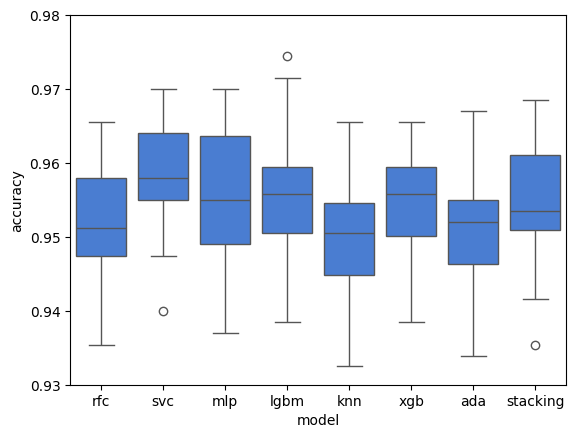

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(data=results_df, x='model', y='accuracy', color="#3378e8")
plt.ylim(0.93, 0.98)